[Text(0.5, 1.0, 'Error of P2 Algorithm')]

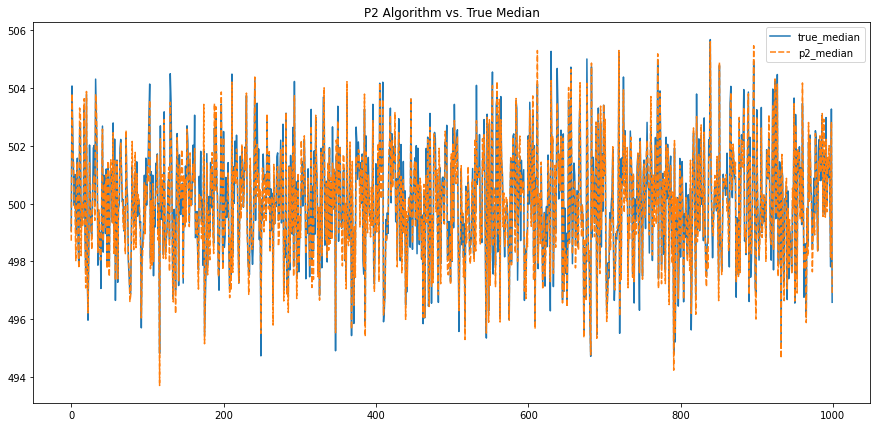

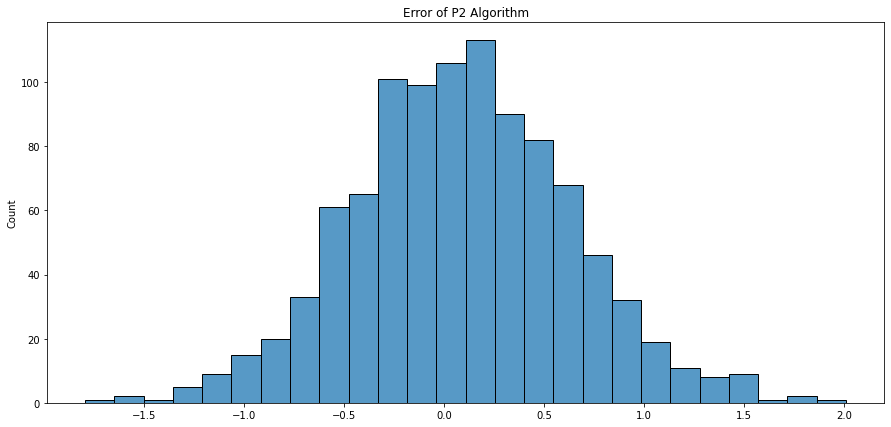

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# P2 Algorithm for dynamic calculation of quantiles and histograms
# without storing observations
# https://www.cs.wustl.edu/~jain/papers/ftp/psqr.pdf
class P2Algorithm:
    def __init__(self, p, verbose=True):
        self.p = p
        self.verbose = verbose
        self.count = 0
        # marker heights
        self.q = []
        # marker positions
        self.n = [1, 2, 3, 4, 5]
        # initial desired positions
        self.n_prime = [1, 2, 3, 4, 5]

    def observe(self, value):
        # sort the first five observations and set marker heights and positions
        self.count += 1
        if self.count <= 5:
            self.q += [value]
            if self.count == 5:
                self.q.sort()
            return
        self._do_algo(value)

    def _find_cell(self, value):
        if value < self.q[0]:
            return 0
        return next((i for i in range(4) if self.q[i] <= value < self.q[i+1]), 3)

    def _do_algo(self, value):
        # find cell k such that marker_heights[i] <= value < marker_heights[i+1]
        k = self._find_cell(value)
        # update extremes if necessary
        self.q[0] = min(self.q[0], value)
        self.q[4] = max(self.q[4], value)

        if self.verbose:
            print("Observed value: ", value)
            print("Fits after marker: ", k+1)
    
        # increase of positions marker k+1 through 4 by 1
        for i in range(k+1, 5):
            self.n[i] += 1

        if self.verbose:
            print("Marker position after observation: ", self.n)

        # update desired positions for all markers
        # ns[1] = count * p / 2;
        # ns[2] = count * p;
        # ns[3] = count * (1 + p) / 2;
        # ns[4] = count;
        self.n_prime[1] = (self.count - 1) * self.p/2 + 1
        self.n_prime[2] = (self.count - 1) * self.p + 1
        self.n_prime[3] = (self.count - 1) * (1+self.p)/2 + 1
        self.n_prime[4] = self.count

        if self.verbose:
            print("Desired marker position: ", self.n_prime)
        
        adjusted = []
        # move markers to desired positions
        for i in range(1, 4):
            d = self.n_prime[i] - self.n[i]
            move_right = (d >= 1 and (self.n[i+1] - self.n[i]) > 1)
            move_left = (d <= -1 and (self.n[i] - self.n[i-1]) > 1)
            if move_right or move_left:
                adjusted += [i]
                d = -1 if d < 0 else 1 # get sign of d
                q_temp = self.parabolic(d, i)
                if self.q[i - 1] < q_temp < self.q[i + 1]:
                    self.q[i] = q_temp
                else:
                    self.q[i] = self.linear(d, i)
                self.n[i] += d

        if self.verbose:
            print("Adjust markers", adjusted)
            print("New marker positions", self.n)
            print("Marker heights: ", self.q)
            print()

    def parabolic(self, d, i):
        return self.q[i] + d / (self.n[i+1] - self.n[i-1]) \
                    * ((self.n[i] - self.n[i-1] + d) * (self.q[i+1] - self.q[i]) / (self.n[i+1] - self.n[i]) \
                    + (self.n[i+1] - self.n[i] - d) * (self.q[i] - self.q[i-1]) / (self.n[i] - self.n[i-1]))

    def linear(self, d, i):
        return self.q[i] + d * (self.q[i + d] - self.q[i]) / (self.n[i + d] - self.n[i])


    @property
    def quantile(self):
        return self.q[2]

true_medians = []
p2_medians = []

for _ in range(1000):
    p2 = P2Algorithm(0.5, verbose=False)

    data = np.random.normal(500, 50, 1000)

    for value in data:
        p2.observe(value)

    true_medians += [np.median(data)]
    p2_medians += [p2.quantile]

results = pd.DataFrame({"true_median": true_medians, "p2_median": p2_medians})
plt.figure(figsize=(15, 7))
sns.lineplot(data=results).set(title="P2 Algorithm vs. True Median")
error = results["true_median"] - results["p2_median"]
plt.figure(figsize=(15, 7))
sns.histplot(data=error).set(title="Error of P2 Algorithm")